
image 1/1 /content/drive/MyDrive/My First Project.v5i.yolov8/test/images/1-29-_jpg.rf.1a3a4df784f93abcbdd2d3cf575c6252.jpg: 640x640 2 cars, 16.3ms
Speed: 2.9ms preprocess, 16.3ms inference, 140.1ms postprocess per image at shape (1, 3, 640, 640)
[YOLO] Class: 2, Confidence: 0.39


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


[FRCNN] Class: 3, Confidence: 0.13
🧠 Final Fuzzy Decision Score: 0.41
🧠 Decision Category: Uncertain


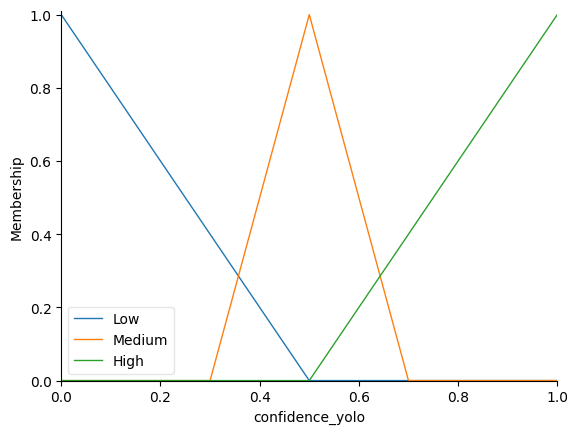

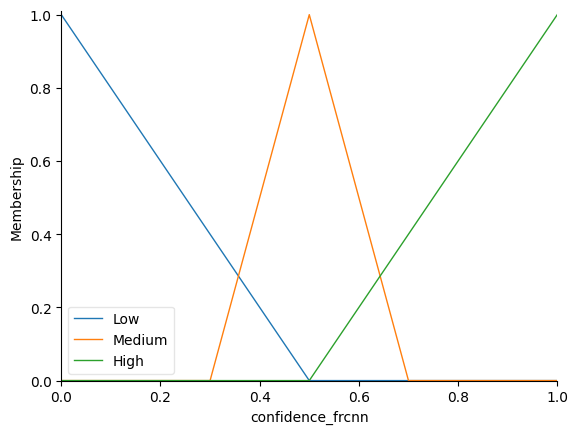

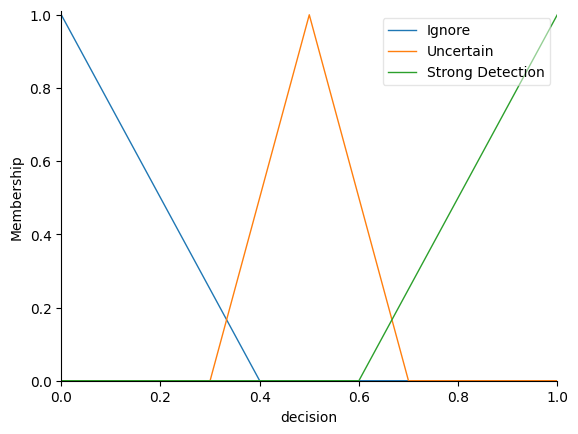

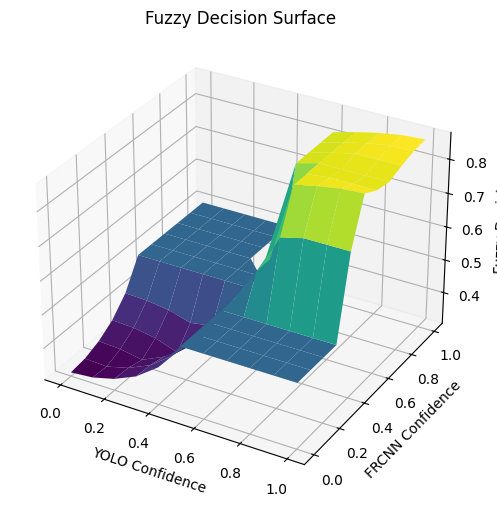

In [1]:
# --------- Install Required Packages ---------
!pip install ultralytics --quiet
!pip install scikit-fuzzy --quiet

# --------- Import Libraries ---------
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision import transforms
from PIL import Image
from ultralytics import YOLO
import numpy as np
import skfuzzy as fuzz
import skfuzzy.control as ctrl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --------- Load Image ---------
image_path = '/content/drive/MyDrive/My First Project.v5i.yolov8/test/images/1-29-_jpg.rf.1a3a4df784f93abcbdd2d3cf575c6252.jpg'
image = Image.open(image_path).convert("RGB")

# --------- Inference with YOLOv8 ---------
yolo_model = YOLO('/content/drive/MyDrive/best weights/Copy of best.pt')
results = yolo_model(image_path)

# Extract highest confidence detection from YOLO
if results[0].boxes.data.shape[0] > 0:
    top_yolo = max(results[0].boxes.data, key=lambda x: x[4])
    yolo_class_id = int(top_yolo[5].item())
    yolo_conf = float(top_yolo[4].item())
    yolo_bbox = top_yolo[:4].tolist()
else:
    yolo_class_id, yolo_conf, yolo_bbox = None, 0.0, []

print(f"[YOLO] Class: {yolo_class_id}, Confidence: {yolo_conf:.2f}")

# --------- Inference with Faster R-CNN ---------
NUM_CLASSES = 4  # Update this based on your classes (+1 for background)
fasterrcnn_model = fasterrcnn_resnet50_fpn(pretrained=False, num_classes=NUM_CLASSES)
state_dict = torch.load('/content/drive/MyDrive/best weights/Copy of fasterrcnn_resnet50_final.pth')
fasterrcnn_model.load_state_dict(state_dict)
fasterrcnn_model.eval()

# Transform image
transform = transforms.Compose([transforms.ToTensor()])
input_tensor = transform(image).unsqueeze(0)

# Run inference
with torch.no_grad():
    outputs = fasterrcnn_model(input_tensor)[0]

# Extract highest confidence detection
if len(outputs['scores']) > 0:
    top_idx = torch.argmax(outputs['scores'])
    frcnn_class_id = int(outputs['labels'][top_idx].item())
    frcnn_conf = float(outputs['scores'][top_idx].item())
    frcnn_bbox = outputs['boxes'][top_idx].tolist()
else:
    frcnn_class_id, frcnn_conf, frcnn_bbox = None, 0.0, []

print(f"[FRCNN] Class: {frcnn_class_id}, Confidence: {frcnn_conf:.2f}")

# --------- Fuzzy Logic System ---------
confidence_yolo = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'confidence_yolo')
confidence_frcnn = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'confidence_frcnn')
decision = ctrl.Consequent(np.arange(0, 1.1, 0.1), 'decision')

confidence_yolo['Low'] = fuzz.trimf(confidence_yolo.universe, [0, 0, 0.5])
confidence_yolo['Medium'] = fuzz.trimf(confidence_yolo.universe, [0.3, 0.5, 0.7])
confidence_yolo['High'] = fuzz.trimf(confidence_yolo.universe, [0.5, 1, 1])

confidence_frcnn['Low'] = fuzz.trimf(confidence_frcnn.universe, [0, 0, 0.5])
confidence_frcnn['Medium'] = fuzz.trimf(confidence_frcnn.universe, [0.3, 0.5, 0.7])
confidence_frcnn['High'] = fuzz.trimf(confidence_frcnn.universe, [0.5, 1, 1])

decision['Ignore'] = fuzz.trimf(decision.universe, [0, 0, 0.4])
decision['Uncertain'] = fuzz.trimf(decision.universe, [0.3, 0.5, 0.7])
decision['Strong Detection'] = fuzz.trimf(decision.universe, [0.6, 1, 1])

rule1 = ctrl.Rule(confidence_yolo['High'] & confidence_frcnn['Medium'], decision['Strong Detection'])
rule2 = ctrl.Rule(confidence_yolo['Low'] | confidence_frcnn['Low'], decision['Uncertain'])
rule3 = ctrl.Rule(confidence_yolo['Medium'] & confidence_frcnn['Medium'], decision['Uncertain'])
rule4 = ctrl.Rule(confidence_yolo['High'] & confidence_frcnn['High'], decision['Strong Detection'])
rule5 = ctrl.Rule(confidence_yolo['Low'] & confidence_frcnn['Low'], decision['Ignore'])
rule6 = ctrl.Rule(confidence_yolo['Medium'] & confidence_frcnn['Low'], decision['Uncertain'])

fuzzy_control = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6])

# --------- Evaluate Fuzzy Decision ---------
def get_fuzzy_decision(yolo_conf, frcnn_conf):
    try:
        yolo_conf = np.clip(yolo_conf, 0.0, 1.0)
        frcnn_conf = np.clip(frcnn_conf, 0.0, 1.0)

        fuzzy_decision = ctrl.ControlSystemSimulation(fuzzy_control)
        fuzzy_decision.input['confidence_yolo'] = yolo_conf
        fuzzy_decision.input['confidence_frcnn'] = frcnn_conf
        fuzzy_decision.compute()

        if 'decision' in fuzzy_decision.output:
            return fuzzy_decision.output['decision']
        else:
            return np.nan
    except Exception as e:
        print(f"[Fuzzy Error] {e}")
        return np.nan

final_decision = get_fuzzy_decision(yolo_conf, frcnn_conf)
print(f"🧠 Final Fuzzy Decision Score: {final_decision:.2f}")

if final_decision < 0.3:
    result = "Ignore"
elif final_decision < 0.6:
    result = "Uncertain"
else:
    result = "Strong Detection"

print(f"🧠 Decision Category: {result}")

# --------- Visualizations ---------
def plot_membership():
    confidence_yolo.view()
    confidence_frcnn.view()
    decision.view()
    plt.show()

def plot_decision_surface():
    yolo_vals = np.arange(0, 1.1, 0.1)
    frcnn_vals = np.arange(0, 1.1, 0.1)
    Y, F = np.meshgrid(yolo_vals, frcnn_vals)
    Z = np.zeros_like(Y)

    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Z[i, j] = get_fuzzy_decision(Y[i, j], F[i, j])

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(Y, F, Z, cmap='viridis')
    ax.set_xlabel('YOLO Confidence')
    ax.set_ylabel('FRCNN Confidence')
    ax.set_zlabel('Fuzzy Decision')
    ax.set_title('Fuzzy Decision Surface')
    plt.show()

plot_membership()
plot_decision_surface()


In [2]:
# --------- Install Required Packages ---------
!pip install ultralytics --quiet
!pip install scikit-fuzzy --quiet

# --------- Import Libraries ---------
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision import transforms
from PIL import Image
from ultralytics import YOLO
import numpy as np
import skfuzzy as fuzz
import skfuzzy.control as ctrl

# --------- Load Image ---------
image_path = '/content/drive/MyDrive/My First Project.v5i.yolov8/test/images/1-29-_jpg.rf.1a3a4df784f93abcbdd2d3cf575c6252.jpg'
image = Image.open(image_path).convert("RGB")

# --------- Inference with YOLOv8 ---------
yolo_model = YOLO('/content/drive/MyDrive/best weights/Copy of best.pt')
results = yolo_model(image_path)

# Extract highest confidence detection from YOLO
if results[0].boxes.data.shape[0] > 0:
    top_yolo = max(results[0].boxes.data, key=lambda x: x[4])
    yolo_class_id = int(top_yolo[5].item())
    yolo_conf = float(top_yolo[4].item())
    yolo_bbox = top_yolo[:4].tolist()
else:
    yolo_class_id, yolo_conf, yolo_bbox = None, 0.0, []

print(f"[YOLO] Class: {yolo_class_id}, Confidence: {yolo_conf:.2f}")

# --------- Inference with Faster R-CNN ---------
NUM_CLASSES = 4  # Update this based on your classes (+1 for background)
fasterrcnn_model = fasterrcnn_resnet50_fpn(pretrained=False, num_classes=NUM_CLASSES)
state_dict = torch.load('/content/drive/MyDrive/best weights/Copy of fasterrcnn_resnet50_final.pth')
fasterrcnn_model.load_state_dict(state_dict)
fasterrcnn_model.eval()

# Transform image
transform = transforms.Compose([transforms.ToTensor()])
input_tensor = transform(image).unsqueeze(0)

# Run inference
with torch.no_grad():
    outputs = fasterrcnn_model(input_tensor)[0]

# Extract highest confidence detection
if len(outputs['scores']) > 0:
    top_idx = torch.argmax(outputs['scores'])
    frcnn_class_id = int(outputs['labels'][top_idx].item())
    frcnn_conf = float(outputs['scores'][top_idx].item())
    frcnn_bbox = outputs['boxes'][top_idx].tolist()
else:
    frcnn_class_id, frcnn_conf, frcnn_bbox = None, 0.0, []

print(f"[FRCNN] Class: {frcnn_class_id}, Confidence: {frcnn_conf:.2f}")

# --------- Fuzzy Logic System ---------
confidence_yolo = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'confidence_yolo')
confidence_frcnn = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'confidence_frcnn')
decision = ctrl.Consequent(np.arange(0, 1.1, 0.1), 'decision')

confidence_yolo['Low'] = fuzz.trimf(confidence_yolo.universe, [0, 0, 0.5])
confidence_yolo['Medium'] = fuzz.trimf(confidence_yolo.universe, [0.3, 0.5, 0.7])
confidence_yolo['High'] = fuzz.trimf(confidence_yolo.universe, [0.5, 1, 1])

confidence_frcnn['Low'] = fuzz.trimf(confidence_frcnn.universe, [0, 0, 0.5])
confidence_frcnn['Medium'] = fuzz.trimf(confidence_frcnn.universe, [0.3, 0.5, 0.7])
confidence_frcnn['High'] = fuzz.trimf(confidence_frcnn.universe, [0.5, 1, 1])

decision['Ignore'] = fuzz.trimf(decision.universe, [0, 0, 0.4])
decision['Uncertain'] = fuzz.trimf(decision.universe, [0.3, 0.5, 0.7])
decision['Strong Detection'] = fuzz.trimf(decision.universe, [0.6, 1, 1])

rule1 = ctrl.Rule(confidence_yolo['High'] & confidence_frcnn['Medium'], decision['Strong Detection'])
rule2 = ctrl.Rule(confidence_yolo['Low'] | confidence_frcnn['Low'], decision['Uncertain'])
rule3 = ctrl.Rule(confidence_yolo['Medium'] & confidence_frcnn['Medium'], decision['Uncertain'])
rule4 = ctrl.Rule(confidence_yolo['High'] & confidence_frcnn['High'], decision['Strong Detection'])
rule5 = ctrl.Rule(confidence_yolo['Low'] & confidence_frcnn['Low'], decision['Ignore'])
rule6 = ctrl.Rule(confidence_yolo['Medium'] & confidence_frcnn['Low'], decision['Uncertain'])

fuzzy_control = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6])

# --------- Evaluate Fuzzy Decision ---------
def get_fuzzy_decision(yolo_conf, frcnn_conf):
    try:
        yolo_conf = np.clip(yolo_conf, 0.0, 1.0)
        frcnn_conf = np.clip(frcnn_conf, 0.0, 1.0)

        fuzzy_decision = ctrl.ControlSystemSimulation(fuzzy_control)
        fuzzy_decision.input['confidence_yolo'] = yolo_conf
        fuzzy_decision.input['confidence_frcnn'] = frcnn_conf
        fuzzy_decision.compute()

        if 'decision' in fuzzy_decision.output:
            return fuzzy_decision.output['decision']
        else:
            return np.nan
    except Exception as e:
        print(f"[Fuzzy Error] {e}")
        return np.nan

final_decision = get_fuzzy_decision(yolo_conf, frcnn_conf)
print(f"🧠 Final Fuzzy Decision Score: {final_decision:.2f}")

if final_decision < 0.3:
    result = "Ignore"
elif final_decision < 0.6:
    result = "Uncertain"
else:
    result = "Strong Detection"

print(f"🧠 Decision Category: {result}")



image 1/1 /content/drive/MyDrive/My First Project.v5i.yolov8/test/images/1-29-_jpg.rf.1a3a4df784f93abcbdd2d3cf575c6252.jpg: 640x640 2 cars, 16.3ms
Speed: 2.6ms preprocess, 16.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)
[YOLO] Class: 2, Confidence: 0.39
[FRCNN] Class: 3, Confidence: 0.13
🧠 Final Fuzzy Decision Score: 0.41
🧠 Decision Category: Uncertain
